<a href="https://colab.research.google.com/github/ConSeanway/BusinessGameRL/blob/master/Demand_Prediction_RL_v5_0_THIS_WORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from math import exp
from math import sqrt
from math import log
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
from gym import spaces
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import TRPO
from stable_baselines import results_plotter
import statistics
import random
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines import SAC
import seaborn as sns
import pandas as pd

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
'''
class Team():
  # Initialization method, behaviorType should specify how we should set the prices
  def __init__(self, teamName, behaviorType="0", initCapacity=150, minPrice=0, maxPrice=75, holdingCost=3, stockoutCost=20, mfgUnitCost=6, fixedCost=1500):
    
    self.teamName = teamName
    self.behaviorType = behaviorType

    self.capacity = initCapacity
    self.minPrice = minPrice
    self.maxPrice = maxPrice

    self.holdingCost = holdingCost
    self.stockoutCost = stockoutCost

    self.mfgUnitCost = mfgUnitCost
    self.fixedCost = fixedCost

    self.price = 0
    self.unitsSold = 0
    self.unitsManufactured = 0

    self.profit = 0
    self.totalProfit = 0

  #######################################################################

  # Basic "GET" functions for some important variables for our team

  def getCapacity(self):
    return self.capacity

  def getMinPrice(self):
    return self.minPrice

  def getMaxPrice(self):
    return self.maxPrice

  def getProfit(self):
    return self.profit

  def getTotalProfit(self):
    return self.totalProfit

  #######################################################################

  # Team name functions

  def getTeamName(self):
    return self.teamName

  ########################################################################

  # Functions relating to the number of units sold

  def setUnitsSold(self, unitsSold):
    self.unitsSold = unitsSold

  def getUnitsSold(self):
    return self.unitsSold

  ########################################################################

  # Pricing-related methods

  # Set price for a given team (while ensuring that we don't go above the maximum)
  def setPrice(self, newPrice):
    if newPrice > self.maxPrice: self.price = self.maxPrice
    elif newPrice < self.minPrice: self.price = self.minPrice
    else: self.price = newPrice

  # Returns the current price for this team
  def getPrice(self):
    return self.price

  # Figure out the price based upon the current period and pricing strategy.  Knowing the period is required for some strategies listed
  def computePrice(self, period=0.0, givenPrice=50):
    behavior = self.behaviorType
    price = 0
    # Apply the correct pricing strategy depending upon the player type
    if behavior == "RL":
      price = givenPrice
    elif behavior == "Standard":
      price = 65 - 5 * period
    elif behavior == "Walmart":
      price = 15
    elif behavior == "Panic":
      price = 80 - 10 * period
    else:
      price = 50
    self.setPrice(price)

  ########################################################

  # Inventory-related methods
  def setUnitsManufactured(self, unitsProduced):
    self.unitsManufactured = unitsProduced

  def computeInvCost(self):
    holdingCost = max(self.holdingCost * (self.unitsManufactured - self.unitsSold), 0)
    stockoutCost = max(self.stockoutCost * (self.unitsSold - self.unitsManufactured), 0)
    invCost = holdingCost + stockoutCost
    return invCost

  ##########################################################

  # Total Cost Computation
  def computeTotalCost(self):
    invCost = self.computeInvCost()
    mfgCost = self.mfgUnitCost * self.unitsManufactured
    fixedCost = self.fixedCost
    totalCost = invCost + mfgCost + fixedCost
    return totalCost

  def computeRevenue(self):
    revenue = min(self.unitsSold * self.price, self.unitsManufactured * self.price)
    return revenue
  
  def computeProfit(self, unitsSold):
    # First, update the number of units sold so that we can use it in later calcs
    self.setUnitsSold(unitsSold)

    revenue = self.computeRevenue()
    cost = self.computeTotalCost()
    self.profit = revenue - cost
    self.totalProfit += self.profit

  ###########################################################

  def reset(self, minPrice=0, maxPrice=75, holdingCost=3, stockoutCost=20, mfgUnitCost=6, fixedCost=1500, startInv=0):

    self.price = 0
    self.unitsSold = 0
    self.unitsManufactured = 0

    self.profit = 0
    self.totalProfit = 0
'''

'\nclass Team():\n  # Initialization method, behaviorType should specify how we should set the prices\n  def __init__(self, teamName, behaviorType="0", initCapacity=150, minPrice=0, maxPrice=75, holdingCost=3, stockoutCost=20, mfgUnitCost=6, fixedCost=1500):\n    \n    self.teamName = teamName\n    self.behaviorType = behaviorType\n\n    self.capacity = initCapacity\n    self.minPrice = minPrice\n    self.maxPrice = maxPrice\n\n    self.holdingCost = holdingCost\n    self.stockoutCost = stockoutCost\n\n    self.mfgUnitCost = mfgUnitCost\n    self.fixedCost = fixedCost\n\n    self.price = 0\n    self.unitsSold = 0\n    self.unitsManufactured = 0\n\n    self.profit = 0\n    self.totalProfit = 0\n\n  #######################################################################\n\n  # Basic "GET" functions for some important variables for our team\n\n  def getCapacity(self):\n    return self.capacity\n\n  def getMinPrice(self):\n    return self.minPrice\n\n  def getMaxPrice(self):\n    return se

In [0]:
'''
The pattern we're going to want to follow is as follows:
1. Allow teams to view the past market conditions, and time period
2. Teams select and submit their prices and number of units manufactured
3. We determine market demand based upon each team's prices
4. Set the market demand for each team
5. Compute each team's profit
'''
'''
# Create a team, make period 1 decisions
RLAgent = Team(teamName="chungus", behaviorType="RL")
RLAgent.computePrice(givenPrice=.64 * 75)
RLAgent.setUnitsManufactured(.3 * 150)

#### Get the demand by splitting it up
demand = 40
RLAgent.computeProfit(demand)
print("Period 1 profit: " + str(RLAgent.getProfit()))


RLAgent.computePrice(givenPrice=50)
RLAgent.setUnitsManufactured(.35 * 150)
demand = 50
RLAgent.computeProfit(demand)
print("Period 2 profit: " + str(RLAgent.getProfit()))
'''

'\n# Create a team, make period 1 decisions\nRLAgent = Team(teamName="chungus", behaviorType="RL")\nRLAgent.computePrice(givenPrice=.64 * 75)\nRLAgent.setUnitsManufactured(.3 * 150)\n\n#### Get the demand by splitting it up\ndemand = 40\nRLAgent.computeProfit(demand)\nprint("Period 1 profit: " + str(RLAgent.getProfit()))\n\n\nRLAgent.computePrice(givenPrice=50)\nRLAgent.setUnitsManufactured(.35 * 150)\ndemand = 50\nRLAgent.computeProfit(demand)\nprint("Period 2 profit: " + str(RLAgent.getProfit()))\n'

In [0]:
class CustomEnv(gym.Env):

  def __init__(self, INIT_BALANCE=0, discRate=0.02, maxPeriods=12):
    super(CustomEnv, self).__init__()

    self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([1, 1]), shape = (2,), dtype=np.float32) 
    self.observation_space = spaces.Box(low=np.array([0, -10000, 0, 0, 0, 0, 0]), high=np.array([6, 10000, 75, 75, 75, 75, 150]), shape=(7,), dtype=np.float32)

    self.time = 1
    self.maxPeriods = 4
    self.reset()

  def step(self, action):

    agentPrice = action[0] * 75
    unitsManufactured = action[1] * 150

    otherTeamPrice = 65 - 5 * self.time
    walmartTeamPrice = 15
    panicTeamPrice = 80 - 10 * self.time

    priceArr = [agentPrice, otherTeamPrice, walmartTeamPrice, panicTeamPrice]

    meanPrice = statistics.mean(priceArr)
    meanDemand = max((75 * len(priceArr)) - (len(priceArr) * meanPrice), 0)

    totalDemand = meanDemand

    demandPct = []
    demandPct = self.weightedRank(priceArr)

    agentOneDemand = demandPct[0] * totalDemand

    revenue = min(agentOneDemand * agentPrice, unitsManufactured * agentPrice)

    variableCost = unitsManufactured * 6
    invCost = max(3 * (unitsManufactured - agentOneDemand), 0) + max(20 * (agentOneDemand - unitsManufactured), 0)
    fixedCost = 1500
    totalCost = variableCost + invCost + fixedCost

    reward = revenue - totalCost    

    self.state = np.array([self.time, reward, agentPrice, otherTeamPrice, walmartTeamPrice, panicTeamPrice, unitsManufactured]).astype(np.float32)
    self.time +=1

    return self.state, reward,self.time > self.maxPeriods,{}
  
  def reset(self):
    self.state = np.array([0, 0, 0, 0, 0, 0, 0]).astype(np.float32)
    self.time = 1
    return self.state

  def weightedRank(self, inputArray):
    direction = -1
    currArray = inputArray

    # Standardize values
    for i in range(len(currArray)):
      if statistics.stdev(currArray) > 0:
        currArray[i] = direction * (currArray[i] - statistics.mean(currArray)) / statistics.stdev(currArray)
      else:
        currArray[i] = 0

    if min(currArray) < 1: currArray = [z + (1.1 - min(currArray)) for z in currArray]

    for i in range(len(currArray)): currArray[i] = log(currArray[i])

    # Conver the logged result into a percentage, then return the array
    pctArray = []
    for i in range(len(currArray)): pctArray.append(currArray[i] / sum(currArray))

    return pctArray

env = CustomEnv()
check_env(env)    

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [0]:
game = CustomEnv()

obs = game.reset()

totalReward = 0

n_steps = 20
for step in range(n_steps):
  print("Step {}".format(step + 1))
  #action = game.action_space.sample()
  priceSet = 0.5
  unitsMfg = 0.2
  action = [priceSet, unitsMfg]
  obs, reward, done, info = game.step(action)
  print('obs=', obs, 'reward=', reward, 'action=', action,'done=', done)
  totalReward += reward
  if done:
    print("Goal reached!", "reward=", reward)
    print("Total reward=", totalReward)
    break

Step 1
obs= [   1.    -920.221   37.5     60.      15.      70.      30.   ] reward= -920.2209973803575 action= [0.5, 0.2] done= False
Step 2
obs= [   2.    -672.534   37.5     55.      15.      60.      30.   ] reward= -672.5344248284075 action= [0.5, 0.2] done= False
Step 3
obs= [   3.    -607.194   37.5     50.      15.      50.      30.   ] reward= -607.1938470394405 action= [0.5, 0.2] done= False
Step 4
obs= [   4.    -694.526   37.5     45.      15.      40.      30.   ] reward= -694.5258912919646 action= [0.5, 0.2] done= True
Goal reached! reward= -694.5258912919646
Total reward= -2894.47516054017


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


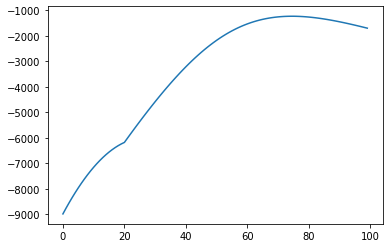

In [0]:
# Price/profit graphing code
game = CustomEnv()

rewardGained = []

for j in np.arange(0, 1, 0.01):

  obs = game.reset()

  totalReward = 0

  n_steps = 20
  for step in range(n_steps):
    price = j
    unitsMfg = .7
    action = [price, unitsMfg]
    obs, reward, done, info = game.step(action)
    #print('obs=', obs, 'reward=', reward, 'action=', action,'done=', done)
    totalReward += reward
    if done:
      #print("Goal reached!", "reward=", reward)
      #print("Total reward=", totalReward)
      rewardGained.append(totalReward)
      break
plt.plot(rewardGained)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


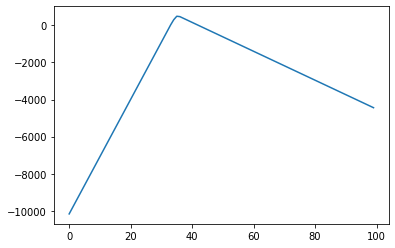

In [0]:
# UnitsManufactured/profit graphing code
game = CustomEnv()

rwGained = []

for i in np.arange(0, 1, 0.01):

  obs = game.reset()

  rTot = 0

  n_steps = 20
  for step in range(n_steps):
    price = .5
    unitsMfg = i
    action = [price, unitsMfg]
    obs, reward, done, info = game.step(action)
    #print('obs=', obs, 'reward=', reward, 'action=', action,'done=', done)
    rTot += reward
    if done:
      #print("Goal reached!", "reward=", reward)
      #print("Total reward=", totalReward)
      rwGained.append(rTot)
      break
plt.plot(rwGained)

In [0]:
game = CustomEnv()

# Create the "model" for our RL
model = TRPO(MlpPolicy, game, verbose=0)

totalRewards = []

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


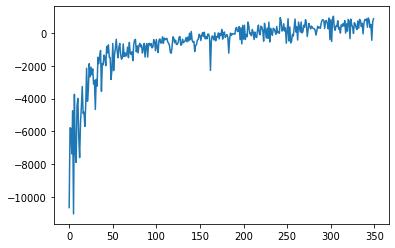

In [0]:
numDataPtsDesired = 150
numTimeSteps = 50


for i in range(numDataPtsDesired):
  # Have the model learn for numTimeSteps more timesteps, and append the number of iterations to our list
  model.learn(total_timesteps=numTimeSteps)

  # Have the model run predictions for a new instance of the game to gather data on performance
  done = False
  obs = game.reset()

  currRewardTot = 0

  # Generate a prediction and then total up the rewards
  while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = game.step(action)
    currRewardTot += rewards

  totalRewards.append(currRewardTot)

plt.plot(totalRewards)

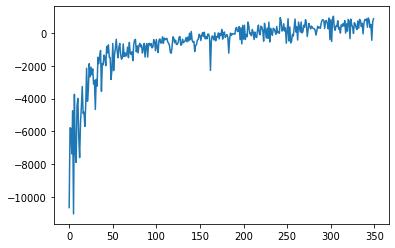

In [0]:
# My lazy way of saving plots that I like temporarily
plt.plot(totalRewards)

In [0]:
#model = TRPO(MlpPolicy, game, verbose=1)
#model.learn(total_timesteps=50000)

In [0]:
# Test the model to see how it performs

dones = False
obs = game.reset()
while not dones:
  action, _states = model.predict(obs)
  obs, rewards, dones, info = game.step(action)
  print(action)
  print(obs)
  print(rewards)

[0.778 0.223]
[ 1.    97.81  58.372 60.    15.    70.    33.511]
97.810033970816
[0.744 0.31 ]
[  2.    167.59   55.765  55.     15.     60.     46.49 ]
167.59016912776337
[0.705 0.349]
[  3.    225.009  52.903  50.     15.     50.     52.295]
225.00901541996063
[0.657 0.36 ]
[  4.    238.478  49.257  45.     15.     40.     53.983]
238.4784113829744


In [0]:
#game.weightedRank([70, 60, 15, 70])

[0.050690329999932976,
 0.22954492710415925,
 0.6690744128959747,
 0.050690329999932976]

In [0]:
# Test the model to see how it performs

rewRecord = []

dataPts = 250
prices = [[0 for x in range(game.maxPeriods)] for y in range(dataPts)]
qtyOrdered = [[0 for x in range(game.maxPeriods)] for y in range(dataPts)]


for i in range(dataPts):
  dones = False
  obs = game.reset()
  thisGameReward = 0.0
  counter = 0

  while not dones:
    action, _states = model.predict(obs)

    prices[i][counter] = action[0] * 75
    qtyOrdered[i][counter] = action[1] * 150

    obs, rewards, dones, info = game.step(action)
    thisGameReward += rewards
    #print(action)
    #print(obs)
    #print(rewards)
    counter += 1
  rewRecord.append(thisGameReward)
prices = np.array(prices)
qtyOrdered = np.array(qtyOrdered)

Reward mean (sum of all period rewards) is: 546.3199925971699
Reward stDev is: 297.26638240994987


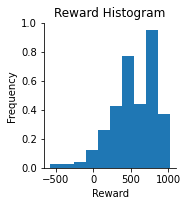

In [0]:
# Create a reward histogram

print("Reward mean (sum of all period rewards) is: " + str(statistics.mean(rewRecord)))
print("Reward stDev is: " + str(statistics.stdev(rewRecord)))

ax = sns.pairplot(pd.DataFrame(rewRecord))
ax.set(title="Reward Histogram", xlabel='Reward', ylabel='Frequency')
plt.show()

Mean price for Pd 0: 55.31733049750328
price Standad Deviation for Pd 0: 4.356609086064586


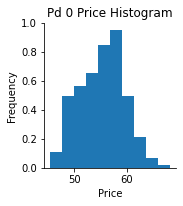

Mean qtyOrdered for Pd 0: 36.19861995577812
qtyOrdered Standad Deviation for Pd 0: 3.3434282335553007


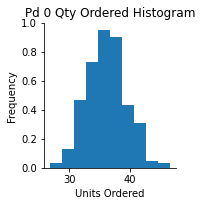

In [0]:
# Pd 0 pricing pairplot
currPeriodPrice = prices[:,0]
print("Mean price for Pd 0: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 0: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 0 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 0 qtyOrdered pairplot
currPdQty = qtyOrdered[:,0]
print("Mean qtyOrdered for Pd 0: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 0: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 0 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()

Mean price for Pd 1: 61.61046862006187
price Standad Deviation for Pd 1: 11.24080619667257


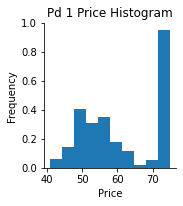

Mean qtyOrdered for Pd 1: 43.13083529770374
qtyOrdered Standad Deviation for Pd 1: 4.698304468549382


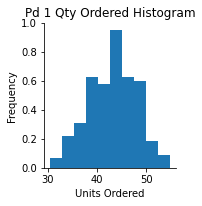

In [0]:
# Pd 1 pricing pairplot
currPeriodPrice = prices[:,1]
print("Mean price for Pd 1: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 1: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 1 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 1 qtyOrdered pairplot
currPdQty = qtyOrdered[:,1]
print("Mean qtyOrdered for Pd 1: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 1: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 1 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()

Mean price for Pd 2: 49.813574373722076
price Standad Deviation for Pd 2: 7.720640997600375


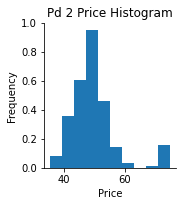

Mean qtyOrdered for Pd 2: 50.533953407406806
qtyOrdered Standad Deviation for Pd 2: 5.301488846335426


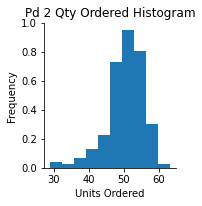

In [0]:
# Pd 2 pricing pairplot
currPeriodPrice = prices[:,2]
print("Mean price for Pd 2: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 2: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 2 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 2 qtyOrdered pairplot
currPdQty = qtyOrdered[:,2]
print("Mean qtyOrdered for Pd 2: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 2: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 2 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()

Mean price for Pd 3: 48.29736401438713
price Standad Deviation for Pd 3: 5.993757145617786


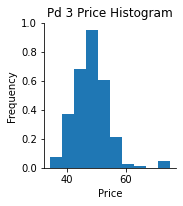

Mean qtyOrdered for Pd 3: 51.127069026231766
qtyOrdered Standad Deviation for Pd 3: 4.354840468662581


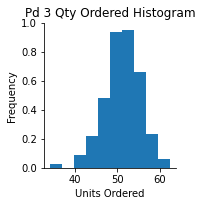

In [0]:
# Pd 3 pricing pairplot
currPeriodPrice = prices[:,3]
print("Mean price for Pd 3: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 3: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 3 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 1 qtyOrdered pairplot
currPdQty = qtyOrdered[:,3]
print("Mean qtyOrdered for Pd 3: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 3: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 3 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()